# Klasifikasi Citra


1. Import library yang diperlukan
2. Load dan unzip data rps.zip dari link dataset yang diberikan
2. Lakukan splitting folder yang mencakup folder train, val, dan test
3. Melakukan Exploration Data Analyst
4. Lakukan Pre-processing dan Data Augmentation yang menurut kamu memberikan dataset yang lebih efisien
5. Implementasikan model transfer learning dengan pre-trained architectures models yang anda inginkan menggunakan Tensorflow Keras, PyTorch ataupun lainnya
6. Lakukan Fit Model dengan epoch yang anda tentukan
7. Evaluate Model dengan menampilkan Plot, Loss, Accuracy serta Classification Report
8. Pilih 10 gambar secara acak pada data test hasil splitting kemudian lakukan predict. Tunjukkan hasilnya kepada asisten.

In [1]:
pip install split-folders

In [2]:
# Import Library
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import splitfolders

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Praktikum ML/Modul 4/Images/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') # Membaca local path
zip_ref.extractall('/tmp') # Extract .zip file
zip_ref.close()

In [5]:
#splittin
splitfolders.ratio('/tmp/rps', output="/tmp/modul5", seed=1337, ratio=(.7, 0.25,0.05))

Copying files: 2520 files [00:02, 1194.48 files/s]


In [6]:
# Definisikan path untuk data train dan data validation

base_dir = '/tmp/modul5'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

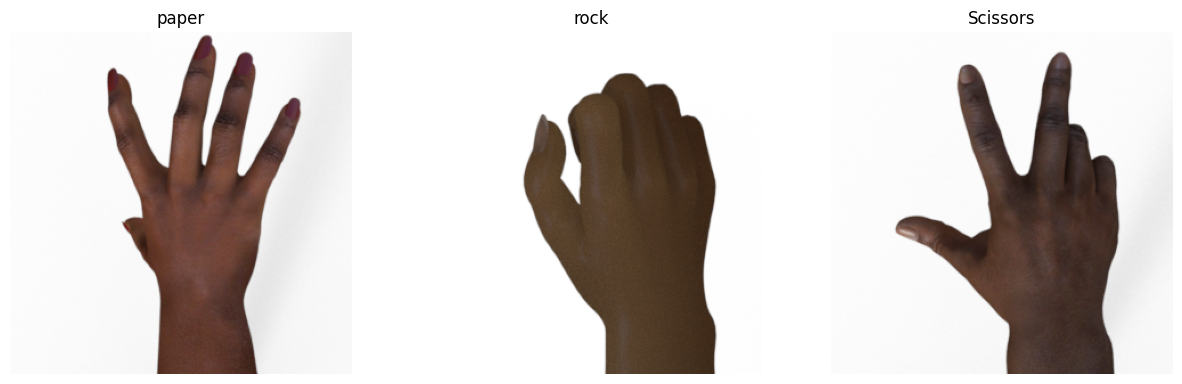

In [7]:
import random
from tensorflow.keras.preprocessing.image import load_img

# Membuat plot dengan dua kolom subplot yang berada dalam satu baris
fig, ax = plt.subplots(1, 3, figsize=(15, 10)) # figsize() untuk set ukurang gambar

sample_paper = random.choice(os.listdir(train_dir + "/paper")) # library random digunakan untuk memilih data secara acak
image = load_img(train_dir + "/paper/" + sample_paper) # library load_img digunakan untuk memuat gambar dengan path yang sudah ditentukan
# set gambar untuk kolom pertama (index 0)
ax[0].imshow(image)
ax[0].set_title("paper")
ax[0].axis("Off")

sample_rock = random.choice(os.listdir(train_dir + "/rock"))
image = load_img(train_dir + "/rock/" + sample_rock)
# set gambar untuk kolom kedua (index 1)
ax[1].imshow(image)
ax[1].set_title("rock")
ax[1].axis("Off")

sample_scissors = random.choice(os.listdir(train_dir + "/scissors"))
image = load_img(train_dir + "/scissors/" + sample_scissors)
# set gambar untuk kolom kedua (index 1)
ax[2].imshow(image)
ax[2].set_title("Scissors")
ax[2].axis("Off")

plt.show()

In [8]:
# normalize the scale in every images using ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

datagen     = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    shear_range=0.2,               # Menambahkan shear transformation dengan kisaran 20%
                    height_shift_range=0.2,        # Menambahkan pergeseran tinggi dengan kisaran 20%
                    fill_mode='nearest')

# implement ImageDataGenerator in train data
train_gen = datagen.flow_from_directory(train_dir, #Direktori data
                                             target_size=(150, 150), #Target size image
                                             batch_size=32, #Menerapkan batch size
                                             class_mode='categorical') #Menerapkan mode kelas

Found 1764 images belonging to 3 classes.


In [9]:
val_gen = datagen.flow_from_directory(validation_dir,
                                      target_size=(150, 150),
                                      batch_size=32,
                                      class_mode='categorical')

# Menampilkan informasi banyak batch data yang digunakan dalam pelatihan dan training
print('Batches train=%d, validation=%d' % (len(train_gen), len(val_gen)))

Found 630 images belonging to 3 classes.
Batches train=56, validation=20


In [10]:
# Fungsi ini akan memplot gambar dalam bentuk grid dengan 1 baris dan 5 kolom, di mana gambar ditempatkan di setiap kolom.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

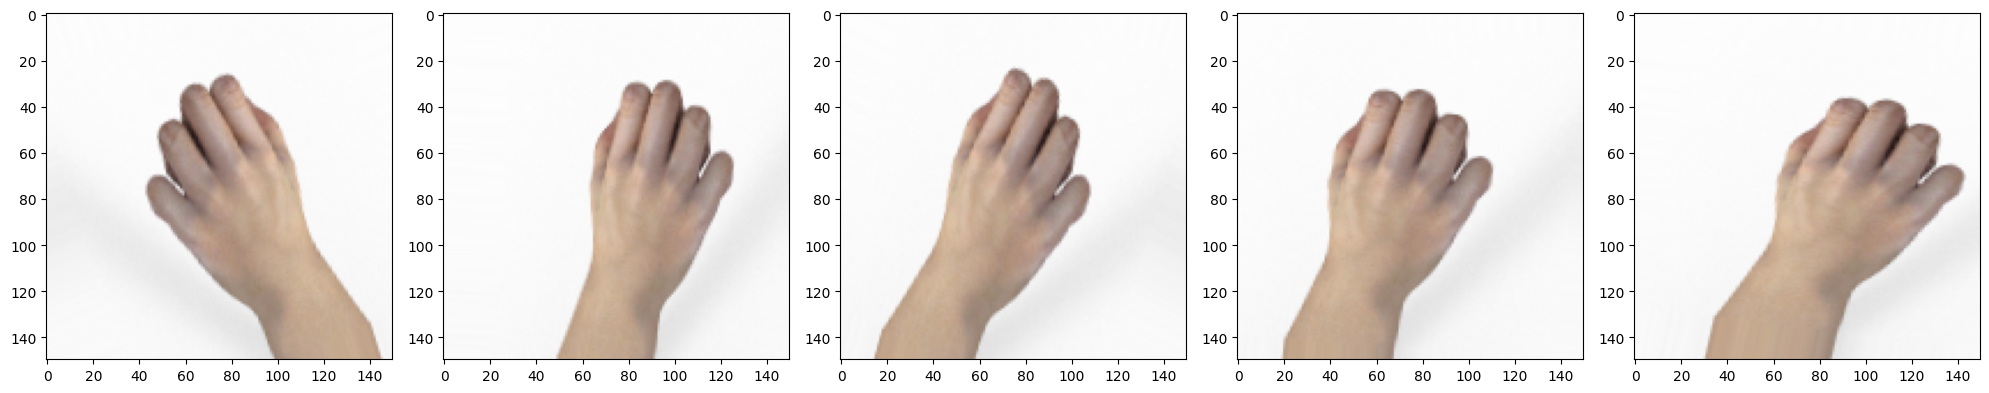

In [11]:
# Visualisasi Data Train yang sudah di-augmentasi
augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
# Pertama, kita import dulu library yang dibutuhkan
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import EfficientNetB3

In [13]:
baseModel = EfficientNetB3(
                      weights="imagenet",  # Load weights pre-trained on ImageNet.
                      input_tensor=Input(shape=(150, 150, 3)), # Set Input Model dengan shape yang sesuai dengan ukuran citra
                      include_top=False,
                      )

43941136/43941136 [==============================] - 2s 0us/step


In [14]:
# Model Summary
baseModel.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0

In [15]:
# Freeze the baseModel karena sudah dilakukan training
baseModel.trainable = False

In [16]:
model = tf.keras.Sequential([
    baseModel,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [17]:
# Model Summary yang kita buat
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 5, 5, 1536)        10783535  
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1536)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 3)                 18435     
                                                                 
Total params: 10801970 (41.21 MB)
Trainable params: 18435 (72.01 KB)
Non-trainable params: 10783535 (41.14 MB)
_________________________________________________________________


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [19]:
history = model.fit(train_gen,
          validation_data=val_gen,
          steps_per_epoch=20, epochs=20)

Epoch 1/20
20/20 [==============================] - 124s 6s/step - loss: 1.2536 - categorical_accuracy: 0.3016 - val_loss: 1.1619 - val_categorical_accuracy: 0.3333
Epoch 2/20
20/20 [==============================] - 132s 7s/step - loss: 1.1398 - categorical_accuracy: 0.3250 - val_loss: 1.1130 - val_categorical_accuracy: 0.4254
Epoch 3/20
20/20 [==============================] - 131s 7s/step - loss: 1.1380 - categorical_accuracy: 0.3313 - val_loss: 1.0932 - val_categorical_accuracy: 0.3333
Epoch 4/20
20/20 [==============================] - 94s 5s/step - loss: 1.1372 - categorical_accuracy: 0.3072 - val_loss: 1.1373 - val_categorical_accuracy: 0.3333
Epoch 5/20
20/20 [==============================] - 129s 7s/step - loss: 1.1234 - categorical_accuracy: 0.3889 - val_loss: 1.0698 - val_categorical_accuracy: 0.5063
Epoch 6/20
20/20 [==============================] - 131s 7s/step - loss: 1.1013 - categorical_accuracy: 0.3812 - val_loss: 1.0680 - val_categorical_accuracy: 0.3460
Epoch 7/20


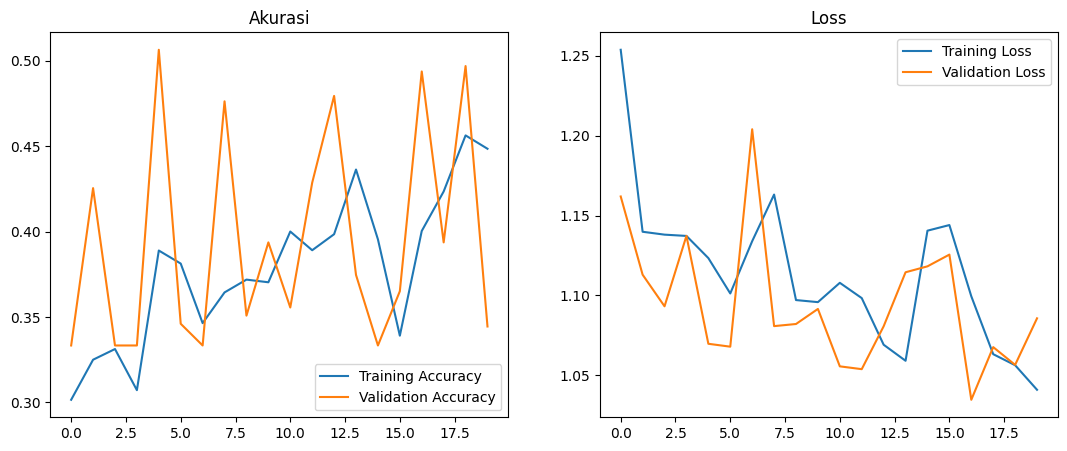

In [20]:
# Visualization Accuracy, Val Accuracy, Loss and Val Loss
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [21]:
# Printout Accuracy and Loss
loss, accuracy = model.evaluate_generator(val_gen)
print("Validation: \nAccuracy = %f  \nLoss = %f " % (accuracy, loss))

<ipython-input-21-3c456f471a43>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(val_gen)


Validation: 
Accuracy = 0.346032  
Loss = 1.089249 


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Memperoleh prediksi probabilitas untuk setiap sampel dalam dataset validasi
y_pred = model.predict(val_gen )

# Mengambil indeks kelas dengan probabilitas tertinggi untuk setiap sampel
y_pred_classes = np.argmax(y_pred, axis=1)

# Mengambil indeks kelas sebenarnya dari dataset validasi
true_classes = val_gen .classes

# Mendapatkan nama kelas dari indeks kelas
class_labels = list(val_gen .class_indices.keys())

# Menampilkan classification report
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

20/20 [==============================] - 51s 2s/step
              precision    recall  f1-score   support

       paper       0.33      0.01      0.02       210
        rock       0.00      0.00      0.00       210
    scissors       0.33      0.99      0.50       210

    accuracy                           0.33       630
   macro avg       0.22      0.33      0.17       630
weighted avg       0.22      0.33      0.17       630



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
model.save('EFFICIENTNET_H5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from keras.models import load_model

In [25]:
model = load_model('EFFICIENTNET_H5.h5')

In [26]:
def load_and_preprocess_images(folder, label, num_images=10):
    image_paths = [os.path.join(folder, file) for file in os.listdir(folder)]
    random.shuffle(image_paths)
    images = []
    labels = []

    for i, image_path in enumerate(image_paths):
        if i >= num_images:
            break

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        image = cv2.resize(image, (150, 150))  # Resize the image to match your model input size
        image = image / 255.0  # Normalize pixel values to [0, 1]

        images.append(image)

        # Extract the label from the folder name
        labels.append(label)

    return np.array(images), labels

In [27]:
import cv2
num_images = 4
rock_images, rock_labels = load_and_preprocess_images('/tmp/modul5/test/rock', 'rock', num_images)
paper_images, paper_labels = load_and_preprocess_images('/tmp/modul5/test/paper', 'paper', num_images)
scissors_images, scissors_labels = load_and_preprocess_images('/tmp/modul5/test/scissors', 'scissors', num_images)

In [28]:
images = np.vstack((rock_images, paper_images, scissors_images))
true_labels = rock_labels + paper_labels + scissors_labels
predictions = model.predict(images)
label_mapping = {0: "paper", 1: "rock", 2: "scissor"}
predicted_labels = [label_mapping[np.argmax(prediction)] for prediction in predictions]

1/1 [==============================] - 4s 4s/step


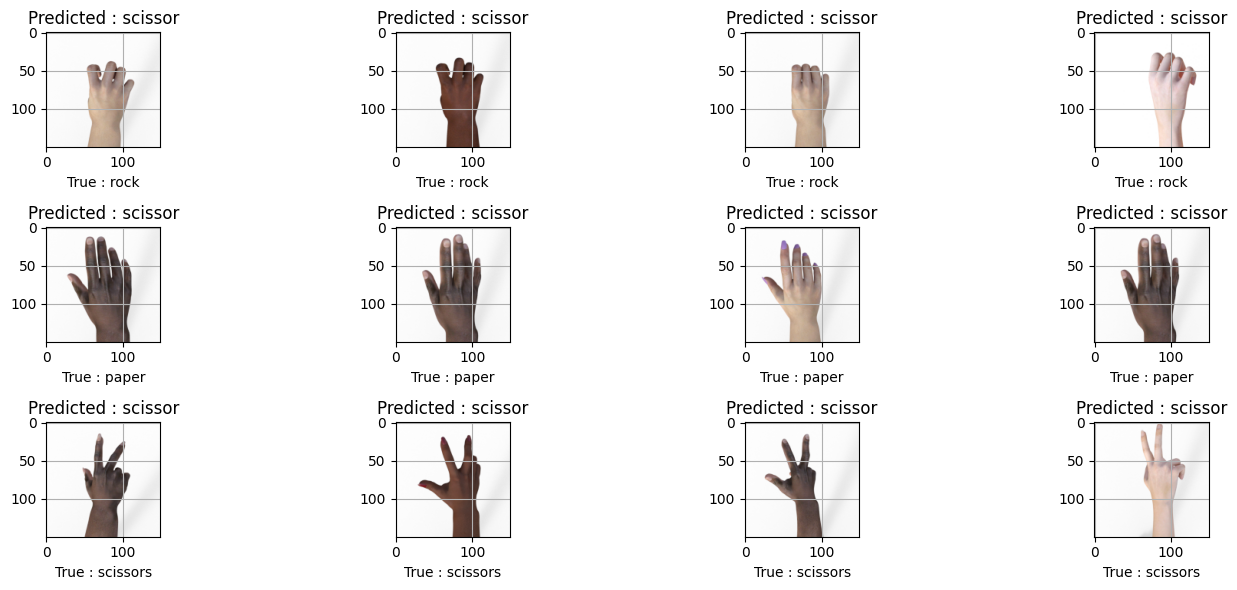

In [29]:
plt.figure(figsize=(15, 6))
for i in range(num_images * 3):
    plt.subplot(3, num_images, i + 1)
    plt.tight_layout()
    plt.imshow(images[i])
    plt.title(f"Predicted : {predicted_labels[i]}")
    plt.xlabel(f"True : {true_labels[i]}")
    plt.grid(visible=None)

plt.show()